# Preferential Attachment from Epistemic Space


Importing required libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output

Define parameters of the model

In [2]:
number_of_authors=100
initial_connections=10
time_steps=100
attempt_per_time_step=10



Function to initialize the epistemic space with random values

In [3]:
def initialize_epistemic_space(number_of_authors):
    #epsitemic_space=np.zeros(number_of_authors,dtype=float)
    epistemic_space=[]
    for i in range(number_of_authors):
        #epsitemic_space[i]=[np.random.random(),np.random.random()]
        epistemic_space.append([np.random.random(),np.random.random()])
        
    return(epistemic_space)




Function to initialize the network with initial edges

In [4]:
def initialize_network(number_of_authors,initial_connections):
    G = nx.erdos_renyi_graph(number_of_authors,0)
    nodes = list(G.nodes())
    for i in range(initial_connections):
        node1,node2=np.random.choice(nodes,size=2)
        G.add_edge(node1,node2)
    return(G)



Function to return degree of each node of a network

In [5]:
def list_degrees(G):
    degrees=np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        degrees[i] = G.degree(i)
    return(degrees)  

Function that executes the W model(where we choose nodes which minimize the epistemic distance)
We choose 1 node at random and then find a node among 10 randomly chosen nodes that has the minimum epistemic distance from the chosen node

In [6]:

def W_model(epistemic_space,G):
    
    nodes = list(G.nodes())
    node1=np.random.choice(nodes,size=1)
    nodes.remove(node1)
    nodes2=np.random.choice(nodes,size=10)
    distances=[]
    point1=np.array([epistemic_space[node1[0]][0],epistemic_space[node1[0]][1]])
    for j in range(len(nodes2)):
        

        
        point2=np.array([epistemic_space[j][0],epistemic_space[j][1] ])
        dist = np.linalg.norm(point1 - point2)
        distances.append(dist)
        
    return(node1[0],np.where(distances==min(distances))[0][0])

Function that executes the P model(where we choose nodes which maximizes mean prestige) We choose 1 node at random with $probabilty(node) = \frac{degree(node)}{Sum(degrees)}$ 
Then find a node among 10 randomly chosen nodes that has the highest degree

In [7]:

def P_model(G):
    nodes = list(G.nodes())
    degrees = list_degrees(G)
    probabilities = degrees / degrees.sum()
    node1=np.random.choice(nodes,p=probabilities)
    #node1=np.random.choice(nodes)
    nodes.remove(node1)
    nodes2=np.random.choice(nodes,size=10)
    return(node1,np.where(degrees[nodes2]==max(degrees[nodes2]))[0][0])

Function that updates epistemic coverage of each publication

In [8]:
def calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage):
    
    m1=G.degree(node1)
    m2=G.degree(node2)
    x1=epistemic_space[node1][0]
    x2=epistemic_space[node2][1]
    y1=epistemic_space[node1][0]
    y2=epistemic_space[node2][1]
    
    point1=float((m1*x1 + m2*x2)/(m1+m2) )
    point2=float((m1*y1 + m2*y2)/(m1+m2))
    
    epistemic_coverage.append([point1,point2])

Function that calculates the acceptance probability of publication of 2 selected authors

In [9]:
def acceptance_Prob_Publication(G,node1,node2):
    degrees = list_degrees(G)
    return ((G.degree(node1) + G.degree(node2))/(degrees.sum()))

Function that evolves the network by selecting authors by P model

In [10]:
def evolve_network_PP(G,epistemic_space,time_steps,attempt_per_time_step):
    
    for t in range(time_steps):
        for _ in range(attempt_per_time_step):
            node1,node2 = P_model(G)
            if np.random.random() < acceptance_Prob_Publication(G,node1,node2) :
                G.add_edge(node1,node2)

Function that evolves the network by selecting authors by W model

In [11]:
def evolve_network_WP(G,epistemic_space,time_steps,attempt_per_time_step):
    epistemic_coverage=[]
    for t in range(time_steps):
        for _ in range(attempt_per_time_step):
            node1,node2 = W_model(epistemic_space,G)
            if np.random.random() < acceptance_Prob_Publication(G,node1,node2) :
                G.add_edge(node1,node2)
                calculate_epistemic_coverage(epistemic_space,G,node1,node2,epistemic_coverage)
    return(epistemic_coverage)

Function to draw network sturcture of given graph

In [12]:
def draw_graph(G):
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, node_size=50, font_size=8)
    plt.show()


Function to plot degree distribution

In [13]:
def plot_degree_distribution(G):
    degrees = dict(G.degree())

    # Calculate the degree distribution
    degree_distribution = [list(degrees.values()).count(i) for i in range(max(degrees.values()) + 1)]

    # Normalize the degree distribution to obtain probabilities
    total_nodes = len(G.nodes())
    degree_distribution_prob = [count / total_nodes for count in degree_distribution]

    # Plot the degree distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_distribution_prob)), degree_distribution_prob, width=0.8, color='b', alpha=0.7)
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree Distribution of the Network')
    plt.xticks(range(len(degree_distribution_prob)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
        

Function to plot heat map of epsitemic coverage of published papers

In [14]:
def plot_epistemic_coverage(epistemic_coverage):
    ec=epistemic_coverage
    x=np.zeros(len(ec))
    y=np.zeros(len(ec))

    for i in range(len(ec)):
        x[i]=ec[i][1]
        y[i]=ec[i][0]
    
    plt.hist2d(x,y)

Function to show the time evolution of network simulation

In [15]:
def run_network_simulation(G,epistemic_space,time_steps,attempt_per_time_step):
    

    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    for frame in range(time_steps):
        evolve_network_WP(G,epistemic_space, 1, attempt_per_time_step)

       
        clear_output(wait=True)
        nx.draw(G, pos=pos, with_labels=True, node_size=50, font_size=8)
        plt.title(f'Time Step: {frame}')
        plt.show()


## WP Model

Collaboration depends upon Epistemic interests and publication on mean prestige

Initializing the network

In [16]:
G=initialize_network(number_of_authors,initial_connections)

Initializing epsitemic space

In [20]:
epistemic_space=initialize_epistemic_space(number_of_authors)

Evolving the network using WP model to calculate epistemic coverage

In [21]:
epistemic_coverage=evolve_network_WP(G,epistemic_space,time_steps,attempt_per_time_step)


Drawing the resulting graph

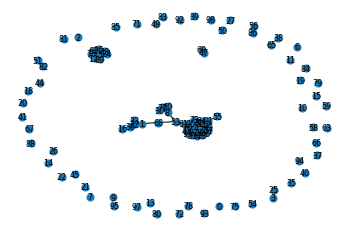

In [22]:
draw_graph(G)

Ploting epsitemic coverage

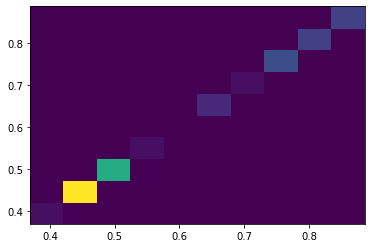

In [23]:
plot_epistemic_coverage(epistemic_coverage)

Plotting degree distribution

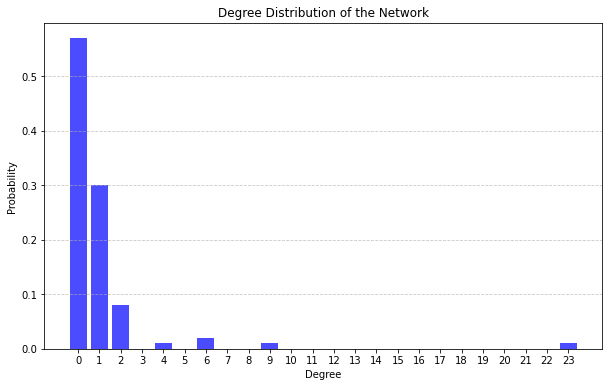

In [24]:
plot_degree_distribution(G)

## PP Model 

Collaboration and publication both depend upon mean prestige

In [25]:
G=initialize_network(number_of_authors,initial_connections)


In [26]:
evolve_network_PP(G,epistemic_space,time_steps,attempt_per_time_step)


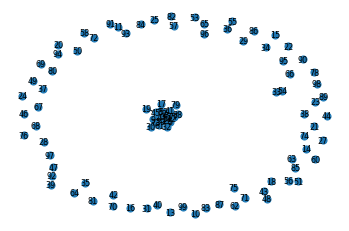

In [27]:
draw_graph(G)

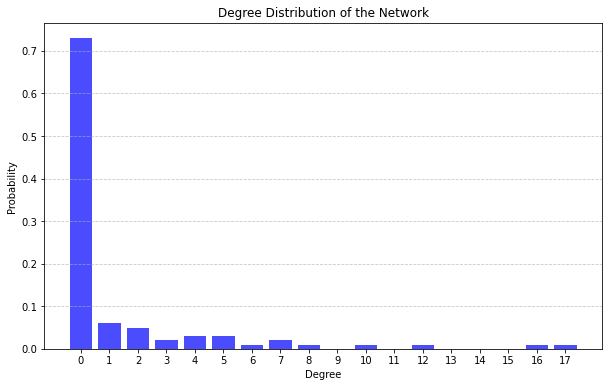

In [28]:
plot_degree_distribution(G)

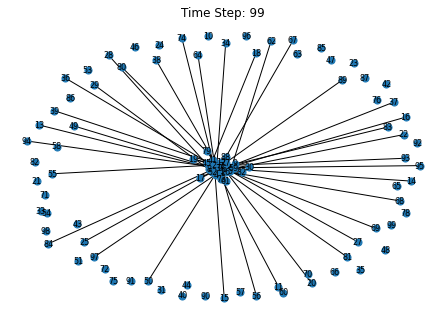

In [29]:
run_network_simulation(G,epistemic_space,time_steps,attempt_per_time_step)